# Capstone Project - The Battle of the Neighborhoods
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)



## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to find the best location for a working office in Bratislava, Slovakia, always based on the information regarding venues and business centers contained in the Foursquare database.

* We are interested on those **neighborhoods that already contain business centers**, as we are considering to rent an office in one of those business centers or in their surroundings, not to build it. Furthermore, we assume that the probability of finding free offices for renting is higher in neighborhoods that already contain business centers.
* Among those, we would choose those neighborhoods that **offer a broader variety of restaurants, coffee shops, green zones and bus/tram stops in Bratislava**.

We will use our data science tools to find the most promising locations based on this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.

## Data <a name="data"></a>

Following data sources will be needed to extract/generate the required information:
* Centers of candidate areas will be obtained from a CSV file that contains their coordinates, exported from Wikipedia.
* Number of venues and their type and location in every neighborhood and close to each business center will be obtained using **Foursquare API**.

Before we get the data and start exploring it, let's download all the libraries that we will need.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import re # Used to convert coordinates from sexagesimal to decimal format.

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

# For the clustering part

from sklearn.cluster import KMeans # Imports k-means method.

import scipy
from scipy.cluster import hierarchy # Imports hierarchical method.
from matplotlib import pyplot as plt 
import pylab

print('Libraries imported.')

Libraries imported.


### 1. Neighborhood Candidates

Let's get latitude & longitude coordinates for centroids of our candidate neighborhoods. For this, we open the CSV file with the coordinates, downloaded from Wikipedia.

In [2]:
coordinates = pd.read_excel ('Coordinates Bratislava.xlsx')
print(coordinates)
print('Data downloaded!')

            neighborhood     latitude    longitude
0            Stare Mesto  48°08'25" N  17°06'40" E
1                Ruzinov  48°08'59" N  17°09'50" E
2                Vrakuna  48°08'45" N  17°12'28" E
3   Podunajske Biskupice  48°07'30" N  17°12'41" E
4             Nove Mesto  48°10'03" N  17°08'17" E
5                   Raca  48°12'42" N  17°09'13" E
6                Vajnory  48°12'16" N  17°12'24" E
7            Karlova Ves  48°09'36" N  17°03'10" E
8               Dubravka  48°11'21" N  17°01'44" E
9                  Lamac  48°11'39" N  17°03'09" E
10                 Devin  48°10'27" N  16°59'08" E
11     Devinska Nova Ves  48°12'40" N  16°58'35" E
12     Zahorska Bystrica  48°14'20" N  17°02'18" E
13             Petrzalka  48°06'41" N  17°06'40" E
14               Jarovce  48°03'54" N  17°06'47" E
15               Rusovce  48°03'17" N  17°08'30" E
16                Cunovo  48°01'43" N  17°11'57" E
Data downloaded!


As we need the coordinates on decimal format, we proceed to transform them. First of all we define functions that will help us with the transformation.

In [3]:
def dms2dd(degrees, minutes, seconds, direction):
    dd = float(degrees) + float(minutes)/60 + float(seconds)/(60*60);
    if direction == 'S' or direction == 'W':
        dd *= -1
    return dd;

def parse_dms(dms):
    parts = re.split('[^\w]+', dms)
    lat = dms2dd(parts[0], parts[1], parts[2], parts[3])
    return (lat)

latitudes = []
longitudes = []

for i in coordinates['latitude']:
    latitude = parse_dms(i)
    latitudes.append(latitude)

for i in coordinates['longitude']:
    longitude = parse_dms(i)
    longitudes.append(longitude)

Now that we have latitudes and longitudes in decimal format, we will create a pandas dataframe where we will link those coordinates to their correspondent neighborhoods.

In [4]:
# define the dataframe columns
column_names = ['Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
neighborhoods['Neighborhood'] = coordinates['neighborhood']
neighborhoods['Latitude'] = latitudes
neighborhoods['Longitude'] = longitudes

neighborhoods

,Neighborhood,Latitude,Longitude
0,Stare Mesto,48.140278,17.111111
1,Ruzinov,48.149722,17.163889
2,Vrakuna,48.145833,17.207778
3,Podunajske Biskupice,48.125000,17.211389
4,Nove Mesto,48.167500,17.138056
5,Raca,48.211667,17.153611
6,Vajnory,48.204444,17.206667
7,Karlova Ves,48.160000,17.052778
8,Dubravka,48.189167,17.028889
9,Lamac,48.194167,17.052500


We now use geopy library to get the latitude and longitude values of the city of Bratislava.

In [5]:
address = 'Bratislava, Slovakia'

geolocator = Nominatim(user_agent="BA_explorer")
location = geolocator.geocode(address)
BA_latitude = location.latitude
BA_longitude = location.longitude
print('The geograpical coordinates of Bratislava are {}, {}.'.format(BA_latitude, BA_longitude))

The geograpical coordinates of Bratislava are 48.1516988, 17.1093063.


Let's visualize the data we have so far, city center location and candidate neighborhood centers:

In [6]:
# create map of Bratislava using latitude and longitude values
map_bratislava = folium.Map(location=[BA_latitude, BA_longitude], zoom_start=10.5)

# add markers to map
for lat, lng, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Neighborhood']):
    label = folium.Popup(neighborhood, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bratislava)  
    
map_bratislava

OK, we now have the coordinates of centers of neighborhoods/areas to be evaluated.

### 2. Foursquare
Now that we have our location candidates, let's use Foursquare API to:

* Filter those neighborhoods which contain business centers.
* Once we have them filtered, get info on the relevant venues in each neighborhood. We're interested in bus/tram stops, 'food' venues, 'outside' venues and 'shops & services' venues.

With this information, we would be ready to start with our analysis.

Foursquare credentials are defined in hidden cell below.

In [7]:
CLIENT_ID = 'IUC1UK5WAJ2RU4VFZURT24RZY10M3MNKCAKFDJFSPJHUCTB5' # your Foursquare ID
CLIENT_SECRET = 'GAFXMDM3JONHBREM5KRTN5IGQ25URYCR0M4T32LDLPI54FVN' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: IUC1UK5WAJ2RU4VFZURT24RZY10M3MNKCAKFDJFSPJHUCTB5
CLIENT_SECRET:GAFXMDM3JONHBREM5KRTN5IGQ25URYCR0M4T32LDLPI54FVN


Now we will define a function to get the nearby venues from the coordinates that we provide to the function.

In [8]:
def getNearbyVenues(neighborhood, latitudes, longitudes, categories, radius):
    
    iterator = list(zip(neighborhood, latitudes, longitudes)) # zip iterators can only be used once, once it is exhausted, 
    # it gives wrong values. If you create a list from it, you have the fix iterator, over which you can iterate several 
    # times like in this case.
    venues_list = []
    for category in categories:
        for neighborhood, lat, lng in iterator:
            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng,
                category, 
                radius)

            # make the GET request
            results = requests.get(url).json()['response']['groups'][0]['items']
            
            # return only relevant information for each nearby venue
            venues_list.append([(
                neighborhood, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

We will focus on those neighborhoods which contain business centers. For that purpose, we will access the API and filter those venues related to the category ID on business centers only.

To cover as much territory as possible, we will take the radius from the center of the neighborhood which would cover all the territory of the smallest neighborhood, 1600 meters, so we avoid to link the same business center to various neighborhoods.

In [9]:
# Category IDs below were taken from Foursquare web site (https://developer.foursquare.com/docs/resources/categories):

business_center = ['56aa371be4b08b9a8d573517'] # For business centers venues.

business_centers = getNearbyVenues(neighborhood=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude'],
                                   categories=business_center,
                                   radius = 1600
                                   )

business_centers

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Stare Mesto,48.140278,17.111111,Adient,48.143852,17.113667,Business Center
1,Stare Mesto,48.140278,17.111111,Eurovea Central 3,48.141051,17.121555,Business Center
2,Stare Mesto,48.140278,17.111111,UNIQ,48.146670,17.105556,Business Center
3,Stare Mesto,48.140278,17.111111,Twin City A,48.145301,17.124231,Business Center
4,Stare Mesto,48.140278,17.111111,Twin City B,48.145429,17.125261,Business Center
5,Stare Mesto,48.140278,17.111111,Twin City C,48.145815,17.126757,Business Center
6,Stare Mesto,48.140278,17.111111,L12 (Landererova 12),48.142177,17.129136,Business Center
7,Stare Mesto,48.140278,17.111111,CBC II.,48.148767,17.125431,Business Center
8,Ruzinov,48.149722,17.163889,Trade center II.,48.145661,17.155110,Business Center
9,Ruzinov,48.149722,17.163889,EcoAutoWash,48.160704,17.173723,Business Center


As we can see in the output above, Stare Mesto and Nove Mesto are the neighborhoods which contain most of the business centers in Bratislava.

We will now create a dataframe with the neighborhoods that indeed contain business centers. With that dataframe we will go again to the API and get all the existing venues in them.

In [10]:
df_final = business_centers[['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude']].drop_duplicates()
df_final = df_final.reset_index(drop=True)
df_final

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude
0,Stare Mesto,48.140278,17.111111
1,Ruzinov,48.149722,17.163889
2,Vrakuna,48.145833,17.207778
3,Nove Mesto,48.167500,17.138056
4,Vajnory,48.204444,17.206667
5,Petrzalka,48.111389,17.111111


Now that we have the list of neighborhoods, we can proceed to analyze the venues contained in each of them.

In [11]:
# 'Root' categories for all tram stops, bus stops, food-related, outside-related and shop&service-related venues
# respectively.

categories = ['52f2ab2ebcbc57f1066b8b51', '52f2ab2ebcbc57f1066b8b4f', '4d4b7105d754a06374d81259', 
              '4d4b7105d754a06377d81259', '4d4b7105d754a06378d81259']

In [12]:
bratislava_venues = getNearbyVenues(neighborhood=df_final['Neighborhood'],
                                    latitudes=df_final['Neighborhood Latitude'],
                                    longitudes=df_final['Neighborhood Longitude'],
                                    categories=categories,
                                    radius = 1600
                                   )
bratislava_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Stare Mesto,48.140278,17.111111,Námestie Ľ. Štúra (tram),48.140364,17.109823,Tram Station
1,Stare Mesto,48.140278,17.111111,"SND (tram, bus)",48.143019,17.112481,Tram Station
2,Stare Mesto,48.140278,17.111111,Šafárikovo námestie (tram),48.141515,17.115994,Tram Station
3,Stare Mesto,48.140278,17.111111,Sad Janka Kráľa - Divadlo Arena (tram),48.135570,17.117001,Tram Station
4,Stare Mesto,48.140278,17.111111,Námestie SNP (tram),48.145218,17.111645,Tram Station


In [13]:
bratislava_venues.shape

(588, 7)

Let's check how many venues were returned for each neighborhood in total

In [14]:
bratislava_venues[['Neighborhood','Venue']].groupby('Neighborhood').count()

,Venue
Neighborhood,
Nove Mesto,129
Petrzalka,120
Ruzinov,119
Stare Mesto,136
Vajnory,23
Vrakuna,61


From this table we can substract that Vajnory and Vrakuna are the two neighborhoods with less venues in Foursquare. Therefore, I could initially expect that the other 4 neighborhoods will include more variety of venues, being more suitable for the office.

Next step is to analyze the venues existing in each neighborhood. For this matter, we will:

* Use one-hot encoding to have each venue linked to each venue category on a binary way. 
* Then, group the venues by neighborhood and take the mean of the frequency of occurrence of each category.

In [15]:
# one hot encoding
bratislava_onehot = pd.get_dummies(bratislava_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
bratislava_onehot['Neighborhood'] = bratislava_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [bratislava_onehot.columns[-1]] + list(bratislava_onehot.columns[:-1])
bratislava_onehot = bratislava_onehot[fixed_columns]

bratislava_onehot.head()

,Neighborhood,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,Bakery,Basketball Court,Beach,Bistro,Bookstore,Bridal Shop,Buffet,Burger Joint,Burrito Place,Bus Stop,Café,Campground,Candy Store,Castle,Chinese Restaurant,Clothing Store,Convenience Store,Curling Ice,Deli / Bodega,Diner,Dog Run,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Event Service,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Forest,Fountain,Furniture / Home Store,Garden,Gastropub,Gift Shop,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Hawaiian Restaurant,Health Food Store,Hot Dog Joint,Indian Restaurant,Insurance Office,Italian Restaurant,Japanese Restaurant,Lake,Liquor Store,Locksmith,Massage Studio,Mobile Phone Shop,Music Store,Outlet Store,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool,Ramen Restaurant,Record Shop,Recreation Center,Restaurant,River,Roof Deck,Salad Place,Sandwich Place,Scenic Lookout,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Slovak Restaurant,Smoke Shop,Soccer Field,Sporting Goods Shop,Squash Court,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,Tapas Restaurant,Tennis Court,Thai Restaurant,Toy / Game Store,Track,Tram Station,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Volleyball Court,Wine Shop,Yoga Studio
0,Stare Mesto,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,Stare Mesto,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,Stare Mesto,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,Stare Mesto,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,Stare Mesto,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [16]:
bratislava_grouped = bratislava_onehot.groupby('Neighborhood').mean().reset_index()
bratislava_grouped

,Neighborhood,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,Bakery,Basketball Court,Beach,Bistro,Bookstore,Bridal Shop,Buffet,Burger Joint,Burrito Place,Bus Stop,Café,Campground,Candy Store,Castle,Chinese Restaurant,Clothing Store,Convenience Store,Curling Ice,Deli / Bodega,Diner,Dog Run,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Event Service,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Forest,Fountain,Furniture / Home Store,Garden,Gastropub,Gift Shop,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Hawaiian Restaurant,Health Food Store,Hot Dog Joint,Indian Restaurant,Insurance Office,Italian Restaurant,Japanese Restaurant,Lake,Liquor Store,Locksmith,Massage Studio,Mobile Phone Shop,Music Store,Outlet Store,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool,Ramen Restaurant,Record Shop,Recreation Center,Restaurant,River,Roof Deck,Salad Place,Sandwich Place,Scenic Lookout,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Slovak Restaurant,Smoke Shop,Soccer Field,Sporting Goods Shop,Squash Court,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,Tapas Restaurant,Tennis Court,Thai Restaurant,Toy / Game Store,Track,Tram Station,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Volleyball Court,Wine Shop,Yoga Studio
0,Nove Mesto,0.007752,0.000000,0.015504,0.000000,0.015504,0.007752,0.000000,0.007752,0.015504,0.000000,0.000000,0.007752,0.000000,0.178295,0.054264,0.000000,0.000000,0.000000,0.000000,0.015504,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015504,0.007752,0.038760,0.007752,0.007752,0.015504,0.000000,0.000000,0.007752,0.000000,0.000000,0.000000,0.000000,0.007752,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007752,0.031008,0.046512,0.007752,0.023256,0.007752,0.000000,0.000000,0.000000,0.000000,0.015504,0.000000,0.000000,0.000000,0.000000,0.000000,0.007752,0.007752,0.007752,0.000000,0.000000,0.007752,0.007752,0.007752,0.000000,0.023256,0.015504,0.023256,0.015504,0.007752,0.000000,0.007752,0.007752,0.000000,0.007752,0.007752,0.015504,0.000000,0.000000,0.000000,0.007752,0.000000,0.000000,0.000000,0.000000,0.007752,0.015504,0.007752,0.015504,0.000000,0.031008,0.007752,0.000000,0.000000,0.000000,0.000000,0.007752,0.124031,0.000000,0.000000,0.000000,0.007752,0.000000,0.000000,0.015504
1,Petrzalka,0.000000,0.016667,0.025000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008333,0.000000,0.000000,0.241667,0.025000,0.008333,0.000000,0.000000,0.008333,0.008333,0.008333,0.000000,0.008333,0.008333,0.025000,0.000000,0.008333,0.016667,0.025000,0.000000,0.000000,0.008333,0.000000,0.000000,0.000000,0.000000,0.008333,0.000000,0.008333,0.000000,0.000000,0.000000,0.025000,0.000000,0.000000,0.000000,0.033333,0.025000,0.025000,0.000000,0.000000,0.008333,0.000000,0.000000,0.008333,0.000000,0.016667,0.000000,0.008333,0.008333,0.008333,0.000000,0.000000,0.000000,0.000000,0.016667,0.000000,0.000000,0.000000,0.016667,0.016667,0.075000,0.008333,0.008333,0.008333,0.000000,0.000000,0.000000,0.025000,0.008333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008333,0.000000,0.000000,0.000000,0.008333,0.016667,0.000000,0.000000,0.000000,0.075000,0.000000,0.008333,0.025000,0.000000,0.000000,0.016667,0.008333,0.000000,0.000000,0.008333,0.000000,0.008333,0.000000,0.000000
2,Ruzinov,0.008403,0.016807,0.008403,0.000000,0.008403,0.000000,0.000000,0.000000,0.000000,0.008403,0.000000,0.000000,0.000000,0.193277,0.033613,0.000000,0.000000,0.000000,0.008403,0.016807,0.008403,0.008403,0.000000,0.000000,0.000000,0.000000,0.008403,0.000000,0.008403,0.000000,0.000000,0.000000,0.008403,0.008403,0.000000,0.000000,0.008403,0.000000,0.000000,0.008403,0.000000,0.000000,0.042017,0.000000,0.008403,0.000000,0.050420

Let's now confirm the size of the new dataframe

In [17]:
bratislava_grouped.shape

(6, 112)

Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [18]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [19]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = bratislava_grouped['Neighborhood']

for ind in np.arange(bratislava_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bratislava_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Nove Mesto,Bus Stop,Tram Station,Café,Gym / Fitness Center,Electronics Store,Gym,Supermarket,Pizza Place,Plaza,Health Food Store
1,Petrzalka,Bus Stop,Pizza Place,Supermarket,Grocery Store,Tennis Court,Dog Run,Gym / Fitness Center,Restaurant,Café,Gym
2,Ruzinov,Bus Stop,Gym,Supermarket,Grocery Store,Tram Station,Playground,Pizza Place,Gastropub,Café,Pharmacy
3,Stare Mesto,Bus Stop,Tram Station,Plaza,Café,Bookstore,Clothing Store,Wine Shop,Italian Restaurant,Gym / Fitness Center,Scenic Lookout
4,Vajnory,Bus Stop,Restaurant,Eastern European Restaurant,Electronics Store,Park,Shipping Store,Burrito Place,Supermarket,Shopping Mall,Farmers Market
5,Vrakuna,Bus Stop,Pizza Place,Café,Eastern European Restaurant,Supermarket,Grocery Store,Park,Drugstore,Electronics Store,Pharmacy


From this view, we can see that bus stops and tram stations are among the most common venues in every neighborhood. It states that there are good communications in those neighborhoods.

If we group the top 10 venues by category, apart from bus stops and tram stations this is what we get per neighborhood:

* **Nove Mesto**: 2 food categories, 3 shop and service categories, 3 outdoor and leisure categories.
* **Petrzalka**: 3 food categories, 2 shop and service categories, 4 outdoor and leisure categories.
* **Ruzinov**: 3 food categories, 3 shop and service categories, 2 outdoor and leisure categories.
* **Stare Mesto**: 2 food categories, 3 shop and service categories, 3 outdoor categories.
* **Vajnory**: 3 food categories, 5 shop and service categories, 1 outdoor category.
* **Vrakuna**: 3 food categories, 5 shop and service categories, 1 outdoor category.

Although the nature of the venues inside each category differs, we can see that the split of the top 10 venues more or less the same in all the neighborhoods under the analysis. We can still point out that the variety inside each category has to be higher in Nove Mesto, Petrzalka, Ruzinov and Stare Mesto, neighborhoods with higher amount of total venues.

## Methodology

In this project we will focus now on finding those neighborhoods in Bratislava that are more suitable to position an office, based on the nature and frequency of the venues located in each of them.

During the data gathering step, we retrieved from the Foursquare API all the existing venues in each neighborhood with business centers, based on the category IDs we are interested in.

In the analysis phase, we will use two different clustering methods to create clusters of similar neighborhoods based on their venues.

We do not want to pre-set the number of clusters. For this purpose, we have applied the hierarchical clustering method, which builds a hierarchy of nodes based on the distance between clusters, calculated through the Euclidean distance between points and visualized in a dendogram.

The second method will be the k-means clustering method, which needs the number of clusters as input. We will apply the same number of clusters as the result of the hierarchical clustering method.

## Analysis

Now we will create clusters of similar neighborhoods, which will help us to determine which are the most suitable ones for the office based on their venues.

### 1. Cluster Neighborhoods

### 1.1 Hierarchical clustering using Scipy
In this part we use Scipy package to cluster the dataset:  
First, we calculate the distance matrix. 

In [20]:
bratislava_grouped_clustering = bratislava_grouped.drop('Neighborhood', 1)

leng = bratislava_grouped_clustering.shape[0]
D = scipy.zeros([leng,leng])
for i in range(leng):
    for j in range(leng):
        D[i,j] = scipy.spatial.distance.euclidean(bratislava_grouped_clustering.values[i], bratislava_grouped_clustering.values[j])

In agglomerative clustering, at each iteration, the algorithm must update the distance matrix to reflect the distance of the newly formed cluster with the remaining clusters in the forest. We will use the 'complete' method for calculating the distance between the newly formed cluster and each.

In [21]:
Z = hierarchy.linkage(D, 'complete')

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


Now, plot the dendrogram:

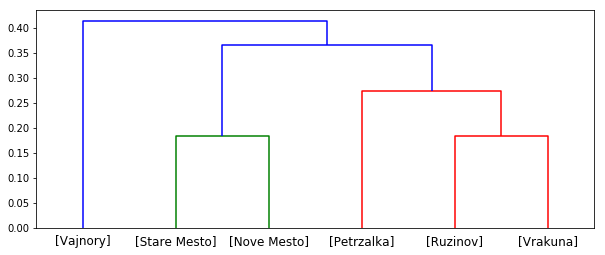

In [22]:
fig = pylab.figure(figsize=(10,4))
def llf(id):
    return '[%s]' % (df_final['Neighborhood'][id])
    
dendro = hierarchy.dendrogram(Z, leaf_label_func=llf, leaf_rotation=0, leaf_font_size =12, orientation = 'top')

Split by frequency of the different venues, which is not considering the total amount of venues in the neighborhood, we clearly see three clusters:

* Vajnory is the unique neighborhood in the first cluster. It is actually part of the countryside of Bratislava.

* Stare Mesto and Nove Mesto, which in reality form the city center of Bratislava, in the northern side of the Danube, are the second cluster.

* Petrzalka on one side of the Danube, and Ruzinov and Vrakuna on the other side, are the bedroom communities of Bratislava, and create the third and last cluster.

Now we will compare this results with the results from the k-means clustering method.

### 1.2 Clustering with k-means

The hierarchical clustering method gives optimal number of clusters of 3. We will now proceed to check whether the k-means clustering method provides the same split between neighborhoods.

In [23]:
# set number of clusters
kclusters = 3

bratislava_grouped_clustering = bratislava_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bratislava_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 2, 2, 1, 0, 2], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [24]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

bratislava_merged = df_final

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
bratislava_merged = bratislava_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

bratislava_merged # check the last columns!

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Stare Mesto,48.140278,17.111111,1,Bus Stop,Tram Station,Plaza,Café,Bookstore,Clothing Store,Wine Shop,Italian Restaurant,Gym / Fitness Center,Scenic Lookout
1,Ruzinov,48.149722,17.163889,2,Bus Stop,Gym,Supermarket,Grocery Store,Tram Station,Playground,Pizza Place,Gastropub,Café,Pharmacy
2,Vrakuna,48.145833,17.207778,2,Bus Stop,Pizza Place,Café,Eastern European Restaurant,Supermarket,Grocery Store,Park,Drugstore,Electronics Store,Pharmacy
3,Nove Mesto,48.167500,17.138056,1,Bus Stop,Tram Station,Café,Gym / Fitness Center,Electronics Store,Gym,Supermarket,Pizza Place,Plaza,Health Food Store
4,Vajnory,48.204444,17.206667,0,Bus Stop,Restaurant,Eastern European Restaurant,Electronics Store,Park,Shipping Store,Burrito Place,Supermarket,Shopping Mall,Farmers Market
5,Petrzalka,48.111389,17.111111,2,Bus Stop,Pizza Place,Supermarket,Grocery Store,Tennis Court,Dog Run,Gym / Fitness Center,Restaurant,Café,Gym


Now we can show how the k-means clustering method has splitted the neighborhoods.

In [25]:
# create map
map_clusters = folium.Map(location=[BA_latitude, BA_longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bratislava_merged['Neighborhood Latitude'], bratislava_merged['Neighborhood Longitude'], bratislava_merged['Neighborhood'], bratislava_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

K-means clustering method shows the same split as the hierarchical method.

### 2. Examine Clusters

Now, we will examine each cluster and determine the discriminating venue categories that distinguish each cluster.

#### 2.1 Vajnory: countryside neighborhood

In [26]:
bratislava_merged.loc[bratislava_merged['Cluster Labels'] == 0, bratislava_merged.columns[[0] + list(range(4, bratislava_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Vajnory,Bus Stop,Restaurant,Eastern European Restaurant,Electronics Store,Park,Shipping Store,Burrito Place,Supermarket,Shopping Mall,Farmers Market


Only 23 venues in Foursquare (the smallest amount among all neighborhoods), which could explain the split between this one and all the other neighborhoods. It contains farmers markets among its most common venues, a clear example of the reason why it is on its own in a separate cluster.

#### 2.2 Cluster of city center neighborhoods

In [27]:
bratislava_merged.loc[bratislava_merged['Cluster Labels'] == 1, bratislava_merged.columns[[0] + list(range(4, bratislava_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Stare Mesto,Bus Stop,Tram Station,Plaza,Café,Bookstore,Clothing Store,Wine Shop,Italian Restaurant,Gym / Fitness Center,Scenic Lookout
3,Nove Mesto,Bus Stop,Tram Station,Café,Gym / Fitness Center,Electronics Store,Gym,Supermarket,Pizza Place,Plaza,Health Food Store


This second cluster includes the two neighborhoods with the highest amount of venues. They form the city center of Bratislava.

They have in common that Bus and Tram Stops are their most common venues. Cafés and Plazas are between their most common venues. Stare Mesto, which means "old town" in Slovak language, also shows Scenic Lookout venues among its top 10 venues, as this is the tourist part of the city. 

Italian food is also among their most common venues, although in Stare Mesto we have restaurants, while in Nove Mesto it is more common to find fast-food restaurants that offer pizza (pizza places).

Both show a broad offer of gyms and other stores that could be visited by workers in their spare time.

#### 2.3 Cluster of dormitory suburbs

In [28]:
bratislava_merged.loc[bratislava_merged['Cluster Labels'] == 2, bratislava_merged.columns[[0] + list(range(4, bratislava_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Ruzinov,Bus Stop,Gym,Supermarket,Grocery Store,Tram Station,Playground,Pizza Place,Gastropub,Café,Pharmacy
2,Vrakuna,Bus Stop,Pizza Place,Café,Eastern European Restaurant,Supermarket,Grocery Store,Park,Drugstore,Electronics Store,Pharmacy
5,Petrzalka,Bus Stop,Pizza Place,Supermarket,Grocery Store,Tennis Court,Dog Run,Gym / Fitness Center,Restaurant,Café,Gym


These three neighborhoods are dormitory suburbs of Bratislava. Therefore, all of them share the same kind of venues in their surroundings. That´s why they were joined together into one cluster. 

We can point out that these clusters were set based on the frequency of their venues over the total number of venues in each neighborhood. That explains that Vrakuna, with only 61 venues in the same searching range used for the other neighborhoods, is on he same cluster than Ruzinov and Petrzalka, with double amount of venues.

* Their first most common venue is bus stops, but Vrakuna and Petrzalka do not have tram stops around their territory yet.
* They all have supermarkets and grocery stores in their top 6 venues.

## Results and Discussion <a name="results"></a>

Our analysis is quite clear about Vajnory. It is the first neighborhood in being discarded as suitable location. A countryside location is not the most appropriate for an office. Based on the information we acquired, the main reasons are:
* It does not have a proper variety of restaurants and other venues, where workers would spend their spare time.
* it is far from the city center by any mean of transportation, which implies long commutes for its workers.

The second neighborhood being excluded is Vrakuna. It is part of the dormitory suburbs, but it is more frequent to see single family homes than blocks of flats, so the density of population in this district is lower. It would be complicated to find a block of offices there, and the variety of venues is not enough.

Due to the lack of tram stops, we would also exclude Petrzalka. It is another dormitory suburb with a lot of potential in the long term, with several projects to build new tram lines around this neighborhood. However, they are long term projects, so this location is not ready for new business centers in the surroundings (excluding the territory located on the Danube riverside, close to Stare Mesto even by walk, where several business centers have been built).

Therefore, from the analysis provided by this report, the top 3 neighborhoods to locate an office would be Ruzinov, Stare Mesto and Nove Mesto.

* Ruzinov is the only dormitory suburb that could be a good location due to its good connections to the city center, and the fact that it is close to residential zones. This could be a good point for workers, who could live closer to the office. Its real estate offer is bigger and prices are lower than in city center. It offers bus but also tram facilities, although not in the same frequency as in the other two locations.
* Stare Mesto is the tourist zone of the city, with several restaurants and varied cafés. It is the neighborhood with the biggest amount of venues, offering also clothing shops, supermarkets, gyms and several plazas with nice terraces for a drink after work. However, in tourist periods, it is always crowded due to the monuments and sightseeing locations located in it. 
In overall, from my own experience in this city, this location should not be recommended for an office, although I consider that locations nearby this neighborhood, close to all those venues but enjoying less crowded parks and plazas, are the best locations in Bratislava for an office.
Based on the analysis of the data contained in this report, Nove Mesto would be the best location for the office:

* It has the same variety of venues than Stare Mesto, but at lower prices.
* Together with Stare Mesto, it is the best communicated with bus and tram with all other neighborhoods, which would reduce the commuting time for workers.
* Close to the old town and with good communications with it, which makes it easier workers to visit its shops and cafés.
* Other venues like gyms and supermarkets in the surroundings of the office, highly valued by the average worker.
* Plazas among their most common venues, with outdoor and some green spaces for the spare time.

Nonetheless, recommended zones should therefore be considered only as a starting point for more detailed analysis which could eventually result in a location which fulfills the requirements in terms of variety of venues but also other factors taken into account and all other relevant conditions for the stakeholder. The results above are just a choice based on the analysis provided in the previous section, but it is not the only possible solution, as depending on how the user values each of the items mentioned, the ranking of neighborhoods can differ.

## Conclusion <a name="conclusion"></a>

Purpose of this project was to identify the best locations to open an office in Bratislava, based on the variety of food, shop&service and outdoor venues and the frequency of bus/tram stops existing in the surroundings of those locations. 

By extracting all business centers in Bratislava, we first identified those neighborhoods which include business centers. Then, we extracted all venues from those neighborhoods and calculated the frequency of each venue category in each neighborhood. 

This calculation allowed us to make comparisons between them. Clustering of those locations based on those frequencies was then performed in order to create major zones of interest (containing more interesting venues from the point of view of workers and people who would commute to the office on daily basis) for final exploration by stakeholders.

Finally, stakeholders will decide which is the optimal office location, based on the aspects analyzed in this report and other characteristics of neighborhoods not mentioned here, like real state availability or price per square meter.